In [1]:
# -*- coding: utf-8 -*-
#  File: HW1_atom.ipynb
#  Project: 'OTUS Homework #1'
#  Created by Gennady Matveev (gm@og.ly) on 16-12-2021.

# **$Homework 1$**  


Goals:   
- Compare four gradient boosting algorithms: sklearn GBT, XGBoost, CatBoost, LightGBM
- Implement EDA, preprocessing, and feature engineering
- Tune hyperparameters

Means:  
- All meaningful programming will be done in ATOM  
    https://tvdboom.github.io/ATOM/about/

Dataset:
- Student Performance on an entrance examination Data Set  https://archive.ics.uci.edu/ml/datasets/Student+Performance+on+an+entrance+examination

Abbreviations:
- EDA: exploratory data analysis
- BO: bayesian optimization
- FE: feature engineering
- DFS: deep feature synthesis

### Import libraries and setup notebook

In [ ]:
import pandas as pd
import numpy as np
from atom import ATOMClassifier
from skopt.space.space import Real, Integer
from scipy.io import arff
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
import warnings
import sys
sys.path.append('../src/')
from utilities import *

#### Miscellaneius settings 

In [ ]:
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
# plt.rcParams['figure.figsize']=(10,5)
sns.set(rc = {'figure.figsize':(8,5)})
warnings.filterwarnings("ignore")
pd.options.display.precision = 4
random_state = 17

#### Parameters of BO

In [2]:
ncalls = 7
n_initpoints = 3

### Load data

In [3]:
data, meta = arff.loadarff('../data/CEE_DATA.arff')
df = pd.DataFrame(data).applymap(lambda x: x.decode('utf-8'))

#### Small bit of preprocessing - XGBoost needs special target encoding

In [4]:
df["Performance"] = df["Performance"].map(
    {'Average': 0, 'Good': 1, 'Vg': 2, 'Excellent': 3})

####  Split target from features

In [5]:
X = df[df.columns[1:]]
y = df[df.columns[0]]

### EDA

#### Basic dataset information

In [6]:
print(meta)
df.head(3)

Dataset: CEEData
	Performance's type is nominal, range is ('Excellent', 'Vg', 'Good', 'Average')
	Gender's type is nominal, range is ('male', 'female')
	Caste's type is nominal, range is ('General', 'OBC', 'SC', 'ST')
	coaching's type is nominal, range is ('NO', 'WA', 'OA')
	time's type is nominal, range is ('ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SEVEN')
	Class_ten_education's type is nominal, range is ('SEBA', 'OTHERS', 'CBSE')
	twelve_education's type is nominal, range is ('AHSEC', 'CBSE', 'OTHERS')
	medium's type is nominal, range is ('ENGLISH', 'OTHERS', 'ASSAMESE')
	Class_ X_Percentage's type is nominal, range is ('Excellent', 'Vg', 'Good', 'Average')
	Class_XII_Percentage's type is nominal, range is ('Excellent', 'Vg', 'Good', 'Average')
	Father_occupation's type is nominal, range is ('DOCTOR', 'SCHOOL_TEACHER', 'BUSINESS', 'COLLEGE_TEACHER', 'OTHERS', 'BANK_OFFICIAL', 'ENGINEER', 'CULTIVATOR')
	Mother_occupation's type is nominal, range is ('OTHERS', 'HOUSE_WIFE', 'SCHOOL_TEACH

,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation
0,3,male,General,NO,ONE,SEBA,AHSEC,ENGLISH,Excellent,Excellent,DOCTOR,OTHERS
1,3,male,OBC,WA,TWO,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,HOUSE_WIFE
2,3,male,OBC,OA,TWO,OTHERS,CBSE,ENGLISH,Excellent,Excellent,BUSINESS,HOUSE_WIFE


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Performance           666 non-null    int64 
 1   Gender                666 non-null    object
 2   Caste                 666 non-null    object
 3   coaching              666 non-null    object
 4   time                  666 non-null    object
 5   Class_ten_education   666 non-null    object
 6   twelve_education      666 non-null    object
 7   medium                666 non-null    object
 8   Class_ X_Percentage   666 non-null    object
 9   Class_XII_Percentage  666 non-null    object
 10  Father_occupation     666 non-null    object
 11  Mother_occupation     666 non-null    object
dtypes: int64(1), object(11)
memory usage: 62.6+ KB


In [8]:
X.describe().T

,count,unique,top,freq
Gender,666,2,male,355
Caste,666,4,General,329
coaching,666,3,WA,449
time,666,6,TWO,368
Class_ten_education,666,3,SEBA,396
twelve_education,666,3,AHSEC,368
medium,666,3,ENGLISH,536
Class_ X_Percentage,666,4,Excellent,511
Class_XII_Percentage,666,4,Excellent,398
Father_occupation,666,8,OTHERS,277


#### Target values distribution

Target distribution by classes:


1    31.5 %
2    29.7 %
0    23.6 %
3    15.2 %
Name: Performance, dtype: object

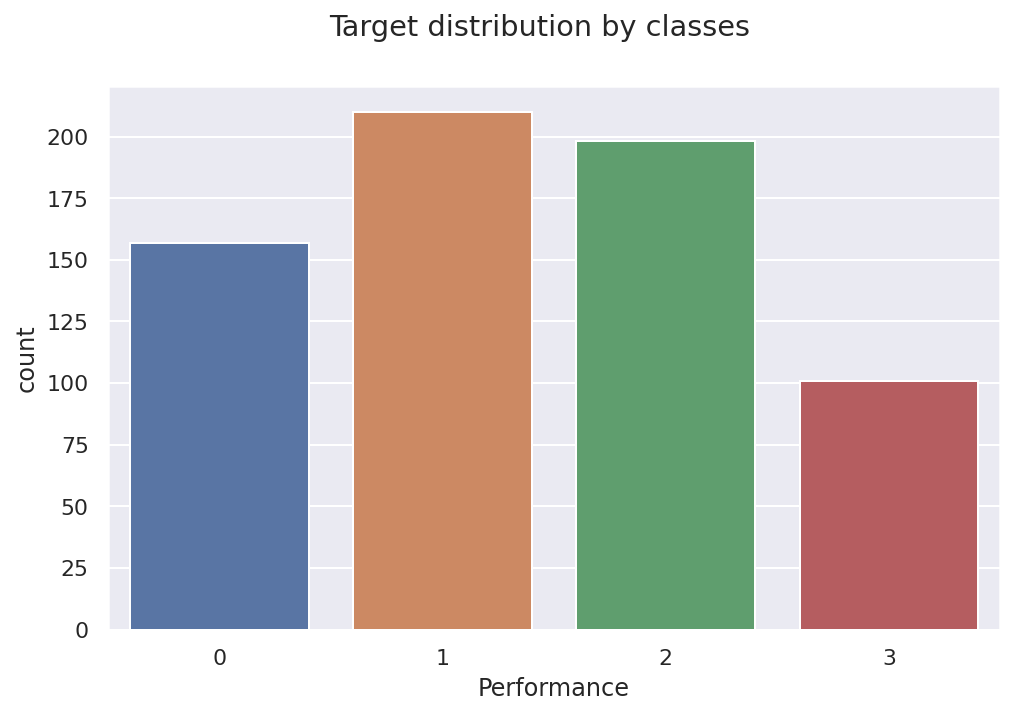

In [9]:
sns.countplot(df['Performance'], data=df)
plt.suptitle('Target distribution by classes')

print(f'Target distribution by classes:')
df["Performance"].value_counts(
    normalize=True).apply(lambda x: f'{x*100:.1f} %')

#### twelve_education and Caste features seem to be important

Text(0.5, 0.98, 'Target distribution:\n"twelve_education" feature')

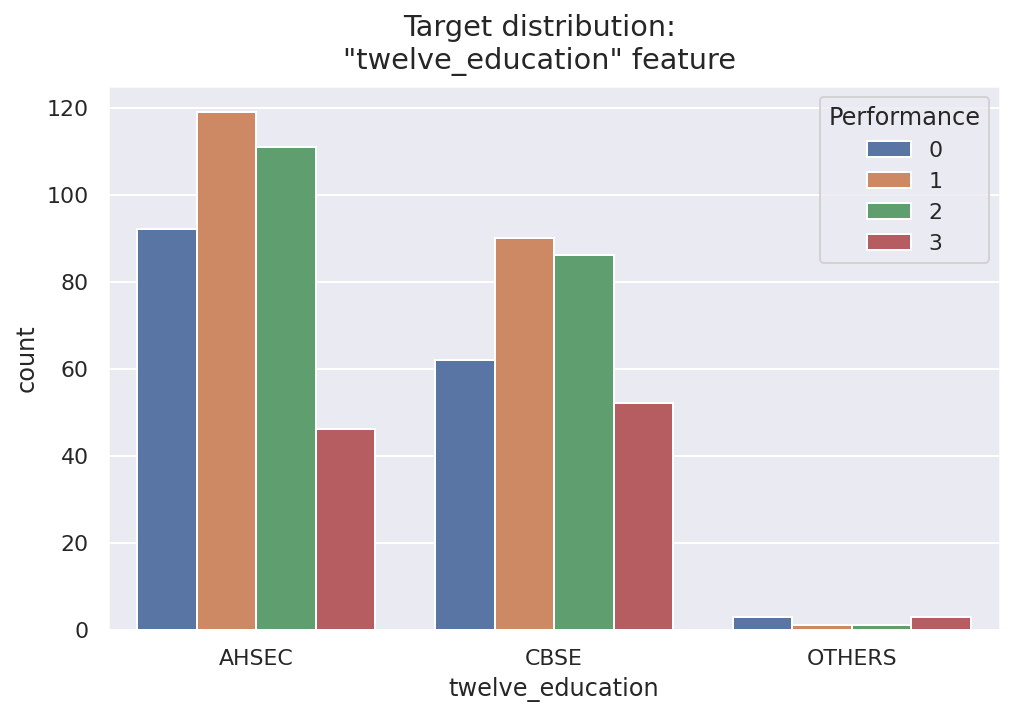

In [10]:
_ = sns.countplot(x=df['twelve_education'], hue=df['Performance'], data=df)
plt.suptitle('Target distribution:\n"twelve_education" feature')

Text(0.5, 0.98, 'Target distribution:\n"Caste" feature')

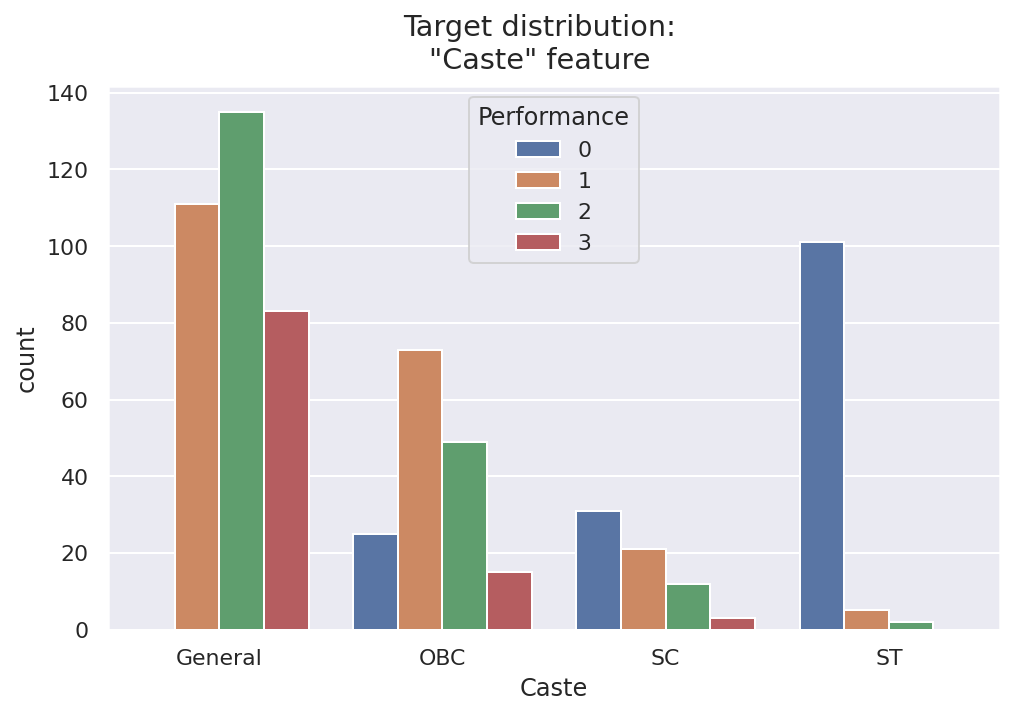

In [11]:
_ = sns.countplot(x=df['Caste'], hue=df['Performance'], data=df)
plt.suptitle('Target distribution:\n"Caste" feature')

#### Run profile report on the dataset

In [12]:
X.profile_report()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Observations:  
- Dataset has no missiong values
- Roughly 10% of rows have duplicates - will ignore this, may be a coincidence
- All features are categorical with smallish number of unique values
- Many features have very uneven distributions with predominance of a single class
- Target values are distributed fairly equally between classes
- A number of feature pairs exhibit sizable correlation that may lead to their collinearity
- Only a few features have significant correlation with the target

### Pipeline

#### Initialise classifier

In [13]:
atom = ATOMClassifier(X, y, test_size=0.25, verbose=2,
                      warnings=False, random_state=random_state)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.

Dataset stats ==================== >>
Shape: (666, 12)
Scaled: False
Categorical features: 11 (100.0%)
Duplicate samples: 44 (6.6%)
-------------------------------------
Train set size: 500
Test set size: 166
-------------------------------------
|    |     dataset |       train |        test |
| -- | ----------- | ----------- | ----------- |
| 0  |   157 (1.6) |   124 (1.8) |    33 (1.1) |
| 1  |   210 (2.1) |   156 (2.2) |    54 (1.7) |
| 2  |   198 (2.0) |   150 (2.1) |    48 (1.5) |
| 3  |   101 (1.0) |    70 (1.0) |    31 (1.0) |



#### Preprocessing - encode features

In [14]:
atom.encode()

Fitting Encoder...
Encoding categorical columns...
 --> Ordinal-encoding feature Gender. Contains 2 classes.
 --> OneHot-encoding feature Caste. Contains 4 classes.
 --> OneHot-encoding feature coaching. Contains 3 classes.
 --> OneHot-encoding feature time. Contains 6 classes.
 --> OneHot-encoding feature Class_ten_education. Contains 3 classes.
 --> OneHot-encoding feature twelve_education. Contains 3 classes.
 --> OneHot-encoding feature medium. Contains 3 classes.
 --> OneHot-encoding feature Class_ X_Percentage. Contains 4 classes.
 --> OneHot-encoding feature Class_XII_Percentage. Contains 4 classes.
 --> OneHot-encoding feature Father_occupation. Contains 8 classes.
 --> OneHot-encoding feature Mother_occupation. Contains 9 classes.


#### Setup Decision Tree classifier as a baseline model and check its performance

In [15]:
atom.run(
    models='tree',
    metric = ["roc_auc_ovr", "f1_weighted"]
)  


Training ========================= >>
Models: Tree
Metric: roc_auc_ovr, f1_weighted


Results for Decision Tree:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9964   f1_weighted: 0.9337
Test evaluation --> roc_auc_ovr: 0.6708   f1_weighted: 0.4791
Time elapsed: 0.016s
-------------------------------------------------
Total time: 0.016s


Final results ==================== >>
Duration: 0.016s
-------------------------------------
Decision Tree --> roc_auc_ovr: 0.6708   f1_weighted: 0.4791 ~


In [16]:
# Remove Decision Tree from the pipeline
atom.delete('tree')

Model deleted successfully!


#### Run the pipeline with default hyperparameters

##### Choose models and metrics

In [17]:
models = ['GBM', 'XGB', 'CATB', 'LGB']
metric = ["roc_auc_ovr", "f1_weighted"]

In [18]:
atom.branch = 'factory'
atom.run(
    models=models,
    metric=metric
)

New branch factory successfully created!

Training ========================= >>
Models: GBM, XGB, CatB, LGB
Metric: roc_auc_ovr, f1_weighted


Results for Gradient Boosting Machine:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9443   f1_weighted: 0.7843
Test evaluation --> roc_auc_ovr: 0.7958   f1_weighted: 0.5544
Time elapsed: 0.345s
-------------------------------------------------
Total time: 0.345s


Results for XGBoost:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9953   f1_weighted: 0.9319
Test evaluation --> roc_auc_ovr: 0.7516   f1_weighted: 0.4646
Time elapsed: 0.472s
-------------------------------------------------
Total time: 0.472s


Results for CatBoost:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9391   f1_weighted: 0.7616
Test evaluation --> roc_auc_ovr: 0.7966   f1_weighted: 0.5308
Time elapsed: 1.804s
------------------

#### Check train and test metrics

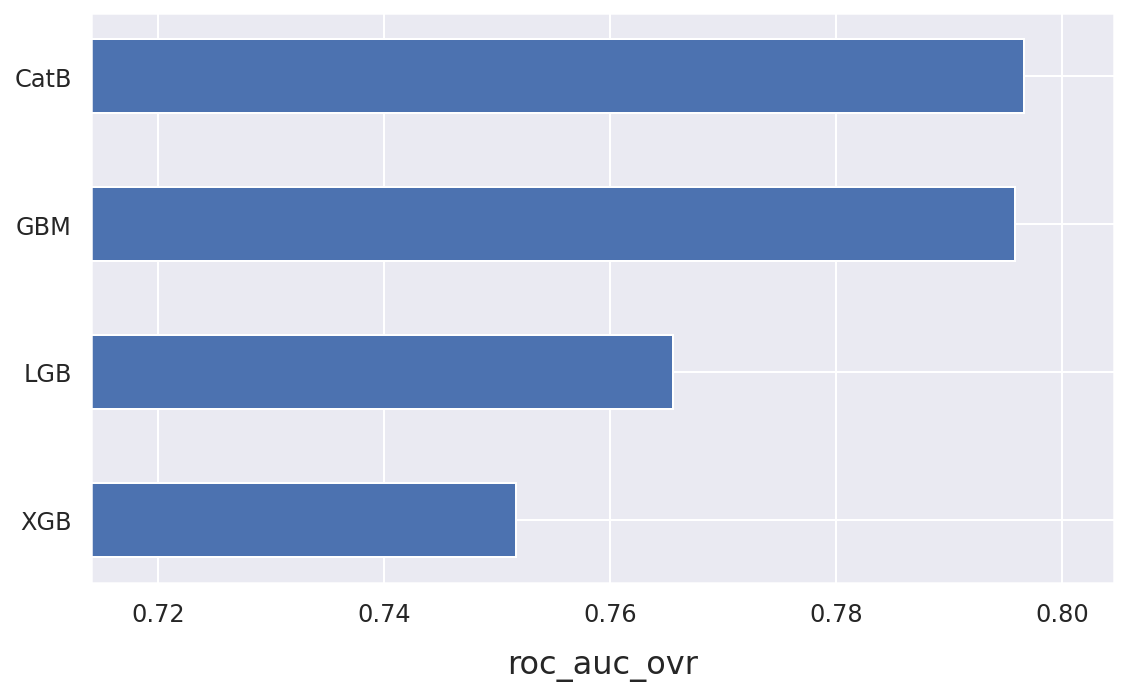

In [19]:
atom.plot_results(figsize=(8,5))
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

Observation:  
- All estimators perform better than baseline model - sanity check passed
- So far GBM and CatBoost seem more promising than XGBoost and LightGBM
- XGBoost and LightGBM are most likely overfitting

#### Check feature importance for one of estimators

In [20]:
# atom.bar_plot('LGB', show=20, figsize=(8,10)) # <-- doesn't work in mybnder, check why

#### Bayesian optimization of hyperparameters

In [21]:
atom.branch = "bo"
atom.run(
    models=["GBM", "XGB", "CATB", "LGB"],
    metric=metric,
    n_calls=ncalls,
    n_initial_points=n_initpoints,
    bo_params={
        "dimensions":[Integer(100, 1000, name="n_estimators"),
                Integer(2, 6, name="max_depth"),
                Real(0.01, 1, "log-uniform", name="learning_rate")],
        "base_estimator": "RF", "max_time": 10000,
    },
    n_bootstrap=5, verbose=2
)

New branch bo successfully created!

Training ========================= >>
Models: GBM, XGB, CatB, LGB
Metric: roc_auc_ovr, f1_weighted


Running BO for Gradient Boosting Machine...
| call             | learning_rate | n_estimators | subsample | criterion | min_samples_split | min_samples_leaf | max_depth | max_features | ccp_alpha | roc_auc_ovr | best_roc_auc_ovr | f1_weighted | best_f1_weighted |    time | total_time |
| ---------------- | ------------- | ------------ | --------- | --------- | ----------------- | ---------------- | --------- | ------------ | --------- | ----------- | ---------------- | ----------- | ---------------- | ------- | ---------- |
| Initial point 1  |        0.0137 |          341 |       --- |       --- |               --- |              --- |         3 |          --- |       --- |      0.7571 |           0.7571 |      0.4775 |           0.4775 |  4.765s |     4.766s |
| Initial point 2  |        0.0161 |          378 |       --- |       --- |              

Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7292 ± 0.0197   f1_weighted: 0.4647 ± 0.0219
Time elapsed: 1.250s
-------------------------------------------------
Total time: 16.063s


Running BO for LightGBM...
| call             | n_estimators | learning_rate | max_depth | num_leaves | min_child_weight | min_child_samples | subsample | colsample_bytree | reg_alpha | reg_lambda | roc_auc_ovr | best_roc_auc_ovr | f1_weighted | best_f1_weighted |    time | total_time |
| ---------------- | ------------ | ------------- | --------- | ---------- | ---------------- | ----------------- | --------- | ---------------- | --------- | ---------- | ----------- | ---------------- | ----------- | ---------------- | ------- | ---------- |
| Initial point 1  |          341 |        0.0137 |         3 |        --- |              --- |               --- |       --- |              --- |       --- |        --- |      0.7608 |           0.7608 |      0.5121 |           0.51

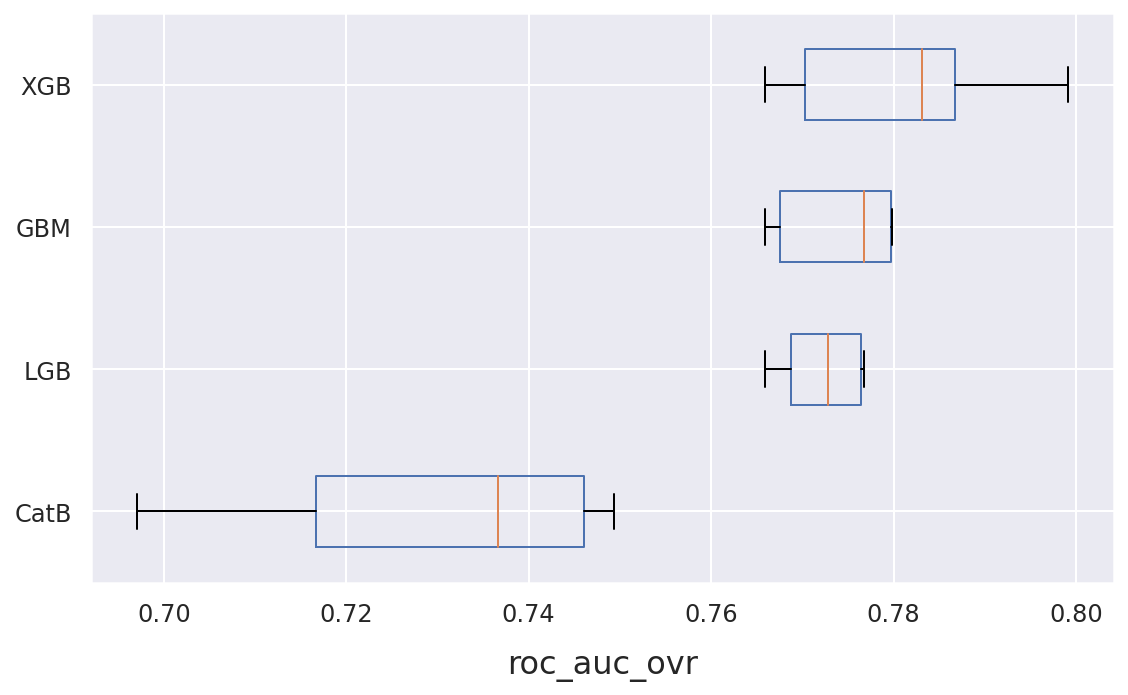

In [22]:
atom.plot_results(figsize=(8,5))
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

Observation:  
- BO leads to models performing more or less on par, with XGBoost leading in ROC_AUC and LightGBM in F1_weighted 
- Overall performance of models has not increased after H/P BO with n_calls=25, n_initial_points=10,  
    it takes several hundred of BO calls to reach ROC_AUC 0.8 and F1_weighted 0,51, probably due  
    to high dimensionality of H/P space

### Feature engineering 

#### DFS in a separate pipeline branch

In [23]:
atom.verbose = 1
atom.branch = "fe"
atom.feature_generation("dfs", n_features=100, operators=["add", "sub", "mul"])

New branch fe successfully created!
Fitting FeatureGenerator...
Creating new features...


#### Make feature selection: check for multicollinearity and use RFECV to reduce their number

In [24]:
atom.feature_selection(
    strategy="RFECV",
    solver="RF",
    n_features=50,
    scoring="logloss",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...


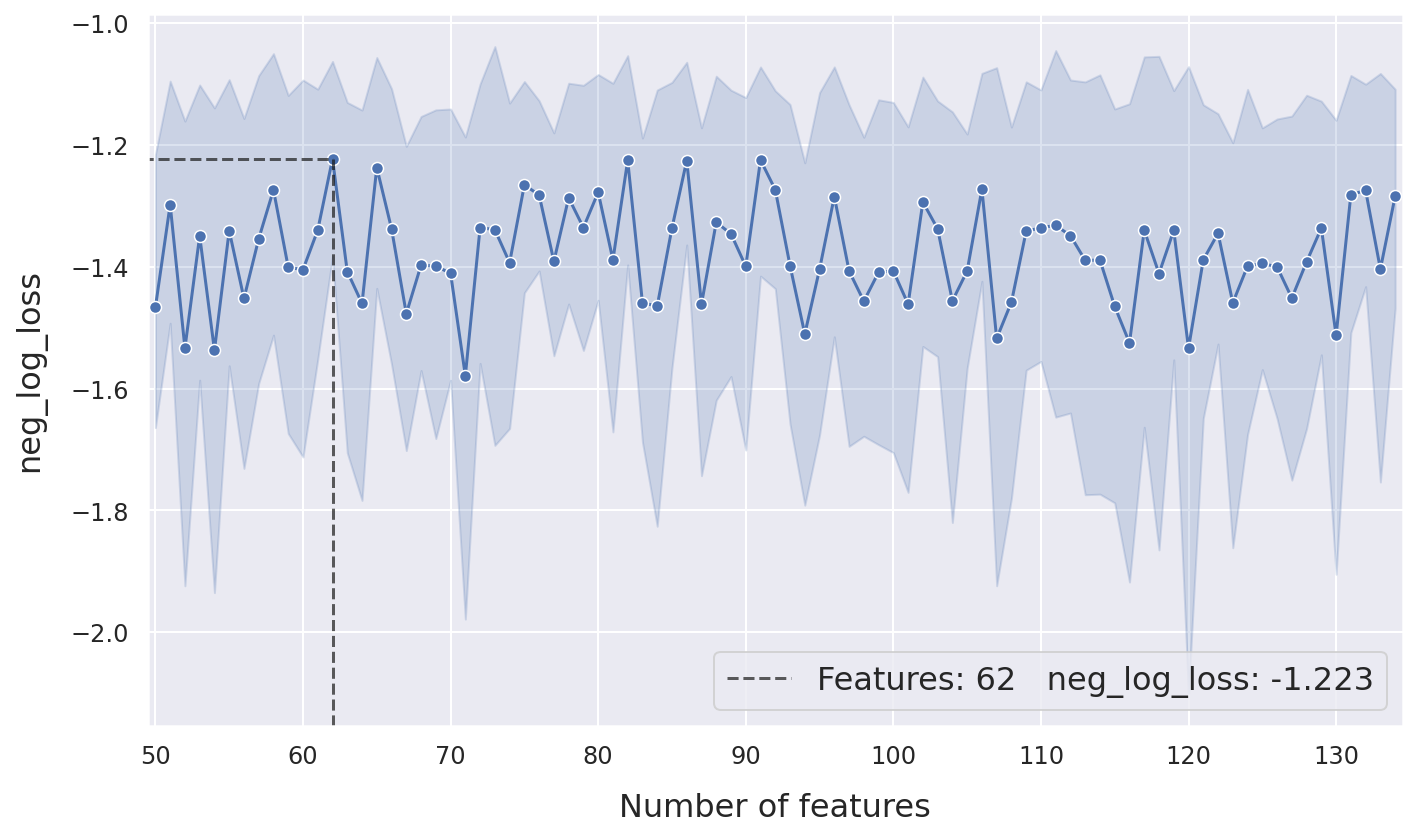

In [25]:
# After applying RFECV, plot the score per number of features
atom.plot_rfecv()

#### Run models with the new set of features

In [26]:
# Check models' performance now
# Add a tag to the model's acronym to not overwrite previous one

atom.run("GBM_fe")
atom.run("XGB_fe")
atom.run("CATB_fe")
atom.run("LGB_fe")


Training ========================= >>
Models: GBM_fe
Metric: roc_auc_ovr, f1_weighted


Results for Gradient Boosting Machine:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9638   f1_weighted: 0.8186
Test evaluation --> roc_auc_ovr: 0.7522   f1_weighted: 0.4956
Time elapsed: 0.441s
-------------------------------------------------
Total time: 0.441s


Final results ==================== >>
Duration: 0.441s
-------------------------------------
Gradient Boosting Machine --> roc_auc_ovr: 0.7522   f1_weighted: 0.4956 ~

Training ========================= >>
Models: XGB_fe
Metric: roc_auc_ovr, f1_weighted


Results for XGBoost:         
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9962   f1_weighted: 0.9319
Test evaluation --> roc_auc_ovr: 0.7529   f1_weighted: 0.4852
Time elapsed: 0.502s
-------------------------------------------------
Total time: 0.502s


Final results ==================== >>
Durat

#### Compare intermediate results

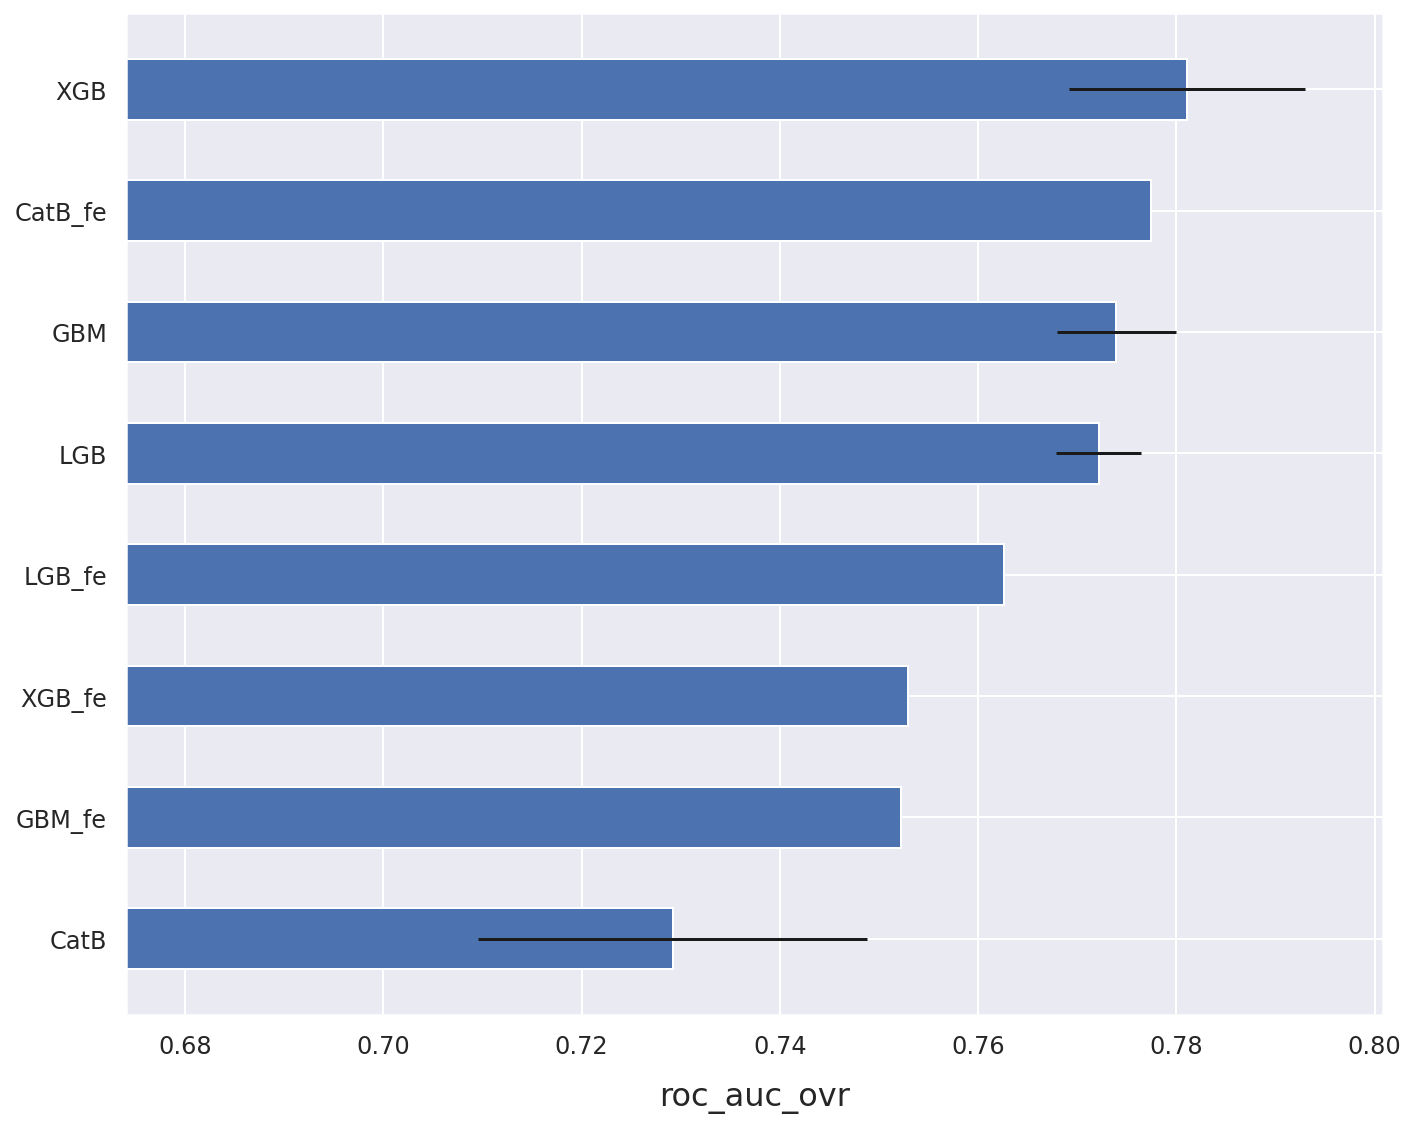

In [27]:
atom.plot_results()
# atom.results
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

Observation:
- Feature engineering doesn't show much promise as models with default parameters perform better in both metrics

#### Run FE-modified models and tune hyperparameters with bayesian optimization

Todo: eleminate line wrap in atom.run output

In [28]:
atom.branch = "fe_bo"

atom.run(
    models=["GBM_fe_bo", "XGB_fe_bo", "CATB_fe_bo", "LGB_fe_bo"],
    metric=metric,
    n_calls=ncalls,
    n_initial_points=n_initpoints,
    bo_params={"dimensions":[Integer(100, 1000, name="n_estimators"),
                Integer(2, 6, name="max_depth"),
                Real(0.01, 1, "log-uniform", name="learning_rate")],
        "base_estimator": "RF", "max_time": 10000
    },
    n_bootstrap=5, verbose=1
)

New branch fe_bo successfully created!

Training ========================= >>
Models: GBM_fe_bo, XGB_fe_bo, CatB_fe_bo, LGB_fe_bo
Metric: roc_auc_ovr, f1_weighted


Running BO for Gradient Boosting Machine...


Iteration 7: 100%|█████████████████████████████████████████████████████████████████| 7/7 [01:19<00:00, 11.31s/it]



Results for Gradient Boosting Machine:         
Bayesian Optimization ---------------------------
Best call --> Initial point 3
Best parameters --> {'n_estimators': 619, 'max_depth': 3, 'learning_rate': 0.011970873248557098}
Best evaluation --> roc_auc_ovr: 0.7608   f1_weighted: 0.5151
Time elapsed: 1m:19s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.952   f1_weighted: 0.7924
Test evaluation --> roc_auc_ovr: 0.7566   f1_weighted: 0.4819
Time elapsed: 2.712s
Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7521 ± 0.0067   f1_weighted: 0.4666 ± 0.0202
Time elapsed: 13.140s
-------------------------------------------------
Total time: 1m:35s


Running BO for XGBoost...


Iteration 7: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:41<00:00,  6.00s/it]



Results for XGBoost:         
Bayesian Optimization ---------------------------
Best call --> Initial point 3
Best parameters --> {'n_estimators': 619, 'max_depth': 3, 'learning_rate': 0.011970873248557098}
Best evaluation --> roc_auc_ovr: 0.758   f1_weighted: 0.4956
Time elapsed: 42.000s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9137   f1_weighted: 0.723
Test evaluation --> roc_auc_ovr: 0.7867   f1_weighted: 0.5303
Time elapsed: 1.538s
Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7646 ± 0.0064   f1_weighted: 0.4878 ± 0.033
Time elapsed: 6.678s
-------------------------------------------------
Total time: 50.218s


Running BO for CatBoost...


Iteration 7: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:23<00:00,  3.40s/it]



Results for CatBoost:         
Bayesian Optimization ---------------------------
Best call --> Initial point 3
Best parameters --> {'n_estimators': 619, 'max_depth': 3, 'learning_rate': 0.011970873248557098}
Best evaluation --> roc_auc_ovr: 0.7592   f1_weighted: 0.4782
Time elapsed: 23.776s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.8621   f1_weighted: 0.5947
Test evaluation --> roc_auc_ovr: 0.7881   f1_weighted: 0.4959
Time elapsed: 0.524s
Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7736 ± 0.0087   f1_weighted: 0.4815 ± 0.0216
Time elapsed: 2.384s
-------------------------------------------------
Total time: 26.686s


Running BO for LightGBM...


Initial point 2:  14%|████████▋                                                    | 1/7 [00:01<00:09,  1.59s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Iteration 4:  43%|███████████████████████████▊                                     | 3/7 [00:07<00:09,  2.45s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Iteration 4:  57%|█████████████████████████████████████▏                           | 4/7 [00:08<00:05,  1.88s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Iteration 6:  71%|██████████████████████████████████████████████▍                  | 5/7 [00:13<00:05,  3.00s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Iteration 7: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.31s/it]



Results for LightGBM:         
Bayesian Optimization ---------------------------
Best call --> Initial point 3
Best parameters --> {'n_estimators': 619, 'max_depth': 3, 'learning_rate': 0.011970873248557098}
Best evaluation --> roc_auc_ovr: 0.7582   f1_weighted: 0.4847
Time elapsed: 16.149s
Fit ---------------------------------------------
Train evaluation --> roc_auc_ovr: 0.9126   f1_weighted: 0.7127
Test evaluation --> roc_auc_ovr: 0.7758   f1_weighted: 0.5003
Time elapsed: 0.653s
Bootstrap ---------------------------------------
Evaluation --> roc_auc_ovr: 0.7578 ± 0.0166   f1_weighted: 0.4772 ± 0.0313
Time elapsed: 2.371s
-------------------------------------------------
Total time: 19.175s


Final results ==================== >>
Duration: 3m:11s
-------------------------------------
Gradient Boosting Machine --> roc_auc_ovr: 0.7521 ± 0.0067   f1_weighted: 0.4666 ± 0.0202 ~
XGBoost                   --> roc_auc_ovr: 0.7646 ± 0.0064   f1_weighted: 0.4878 ± 0.033
CatBoost           

#### Compare results - final table

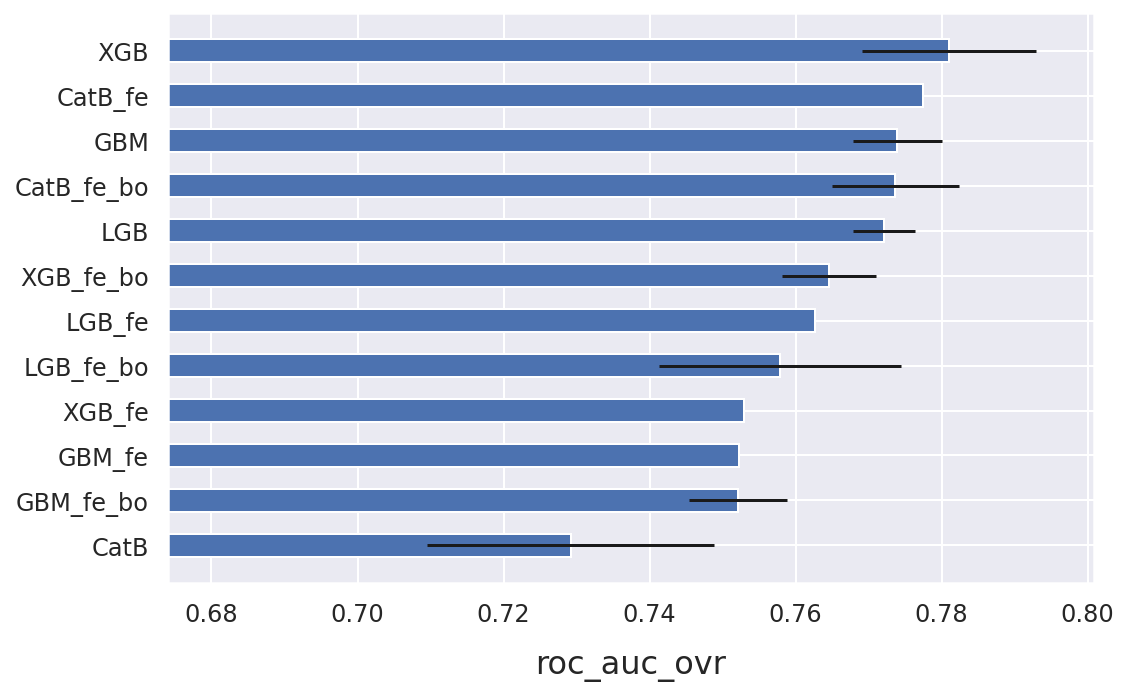

In [29]:
atom.plot_results(figsize=(8, 5))
atom.results
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

Observation:  
- And the winner is ...
- ...on BO and FE

#### Learning curves

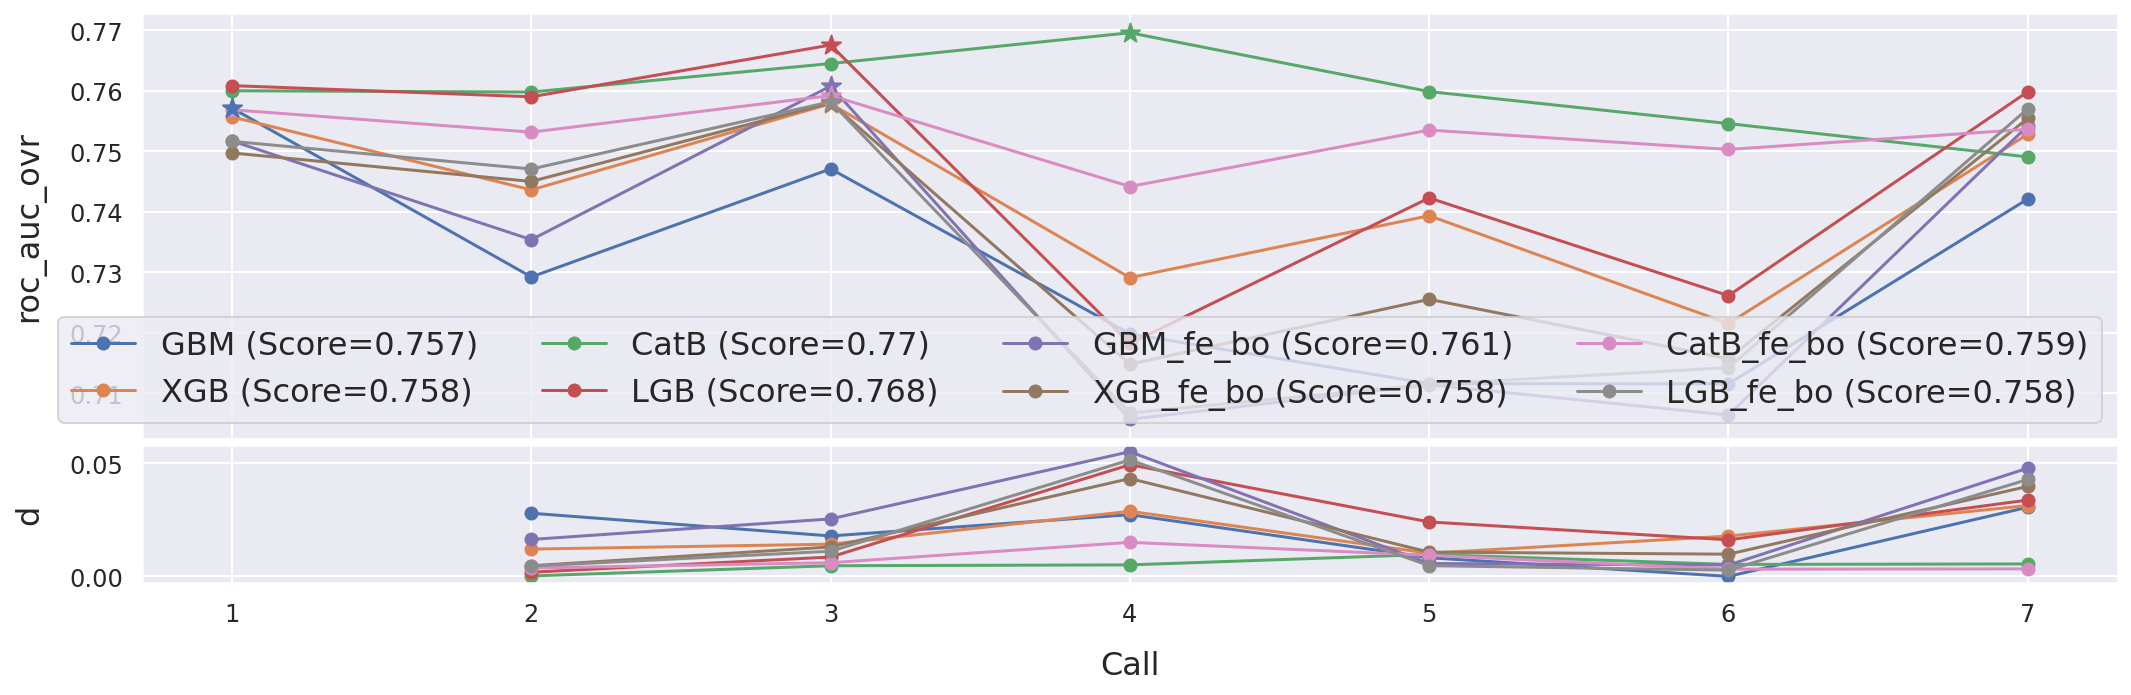

In [30]:
atom.plot_bo(figsize=(16,5))

In [31]:
# with atom.canvas(2, 2, title="Models evaluation"):
#     model_list = ["XGB","LGB"]
#     for m in model_list:
#         atom.plot_evals(m, title=f"{m}", figsize=(8,5)) # <-- doesn't work in mybnder, check why

#### One model exploration - show-off

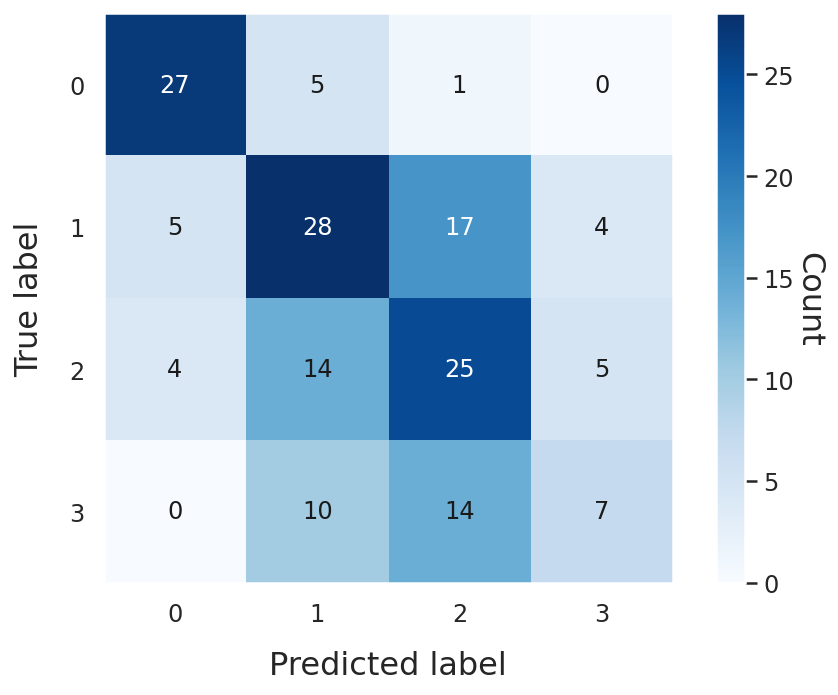

In [32]:
atom.plot_confusion_matrix("CATB", figsize=(8,5))

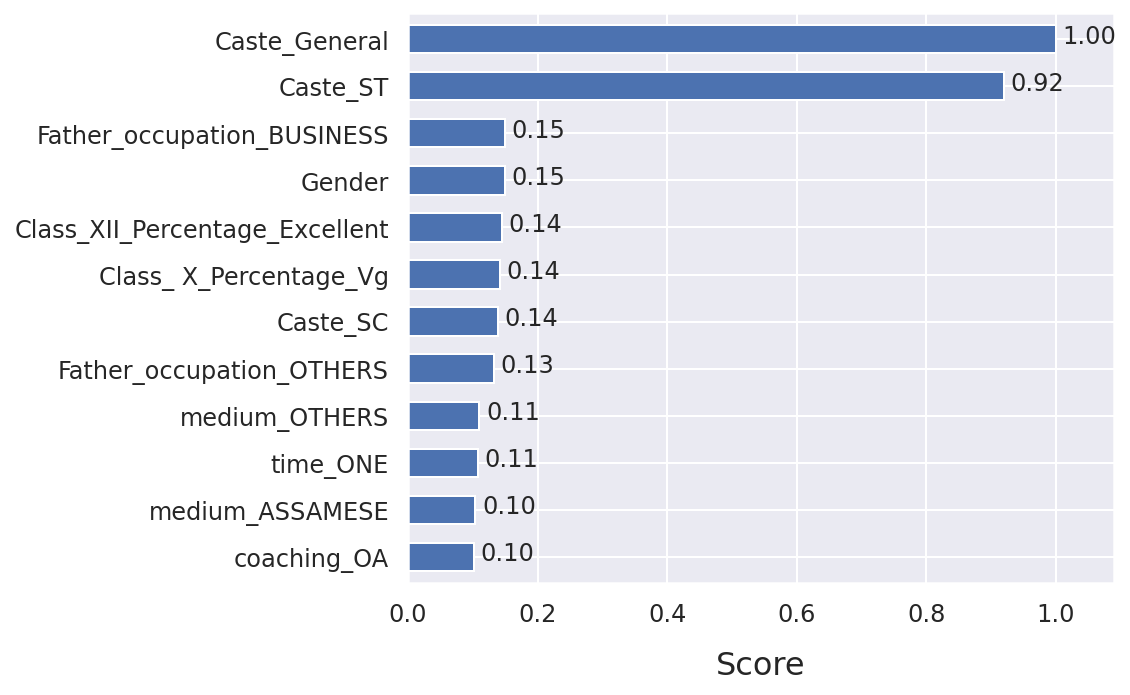

In [33]:
atom.plot_feature_importance("CATB", 12, figsize=(8,5))

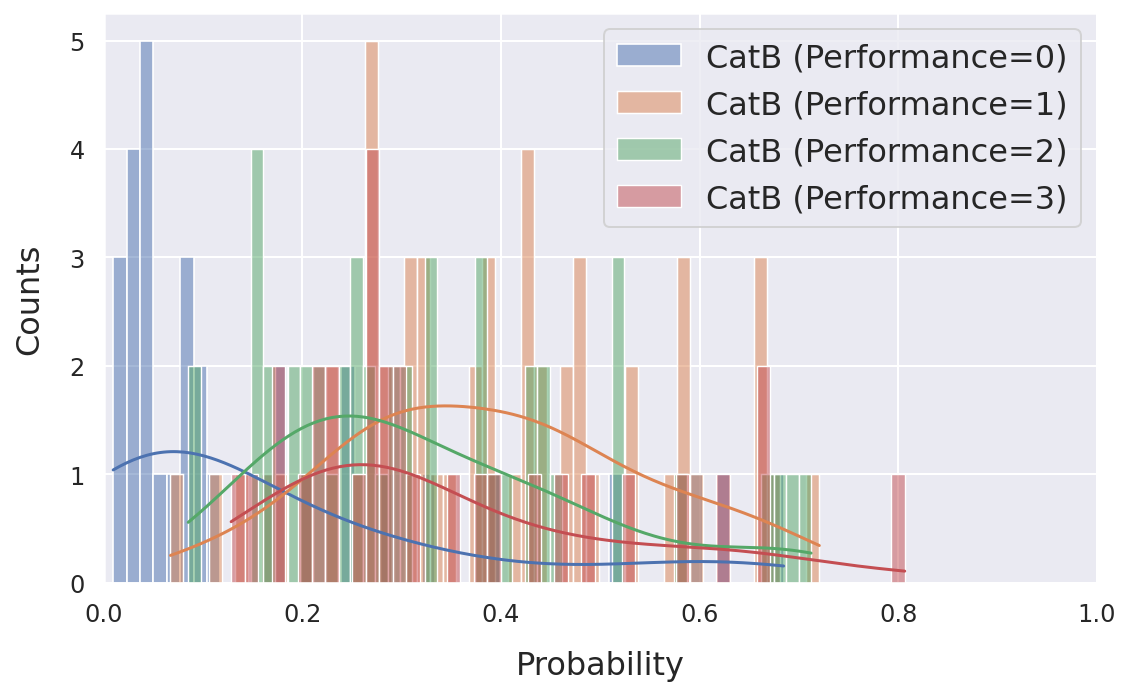

In [34]:
atom.plot_probabilities('CATB', figsize=(8,5))

### Final thoughts

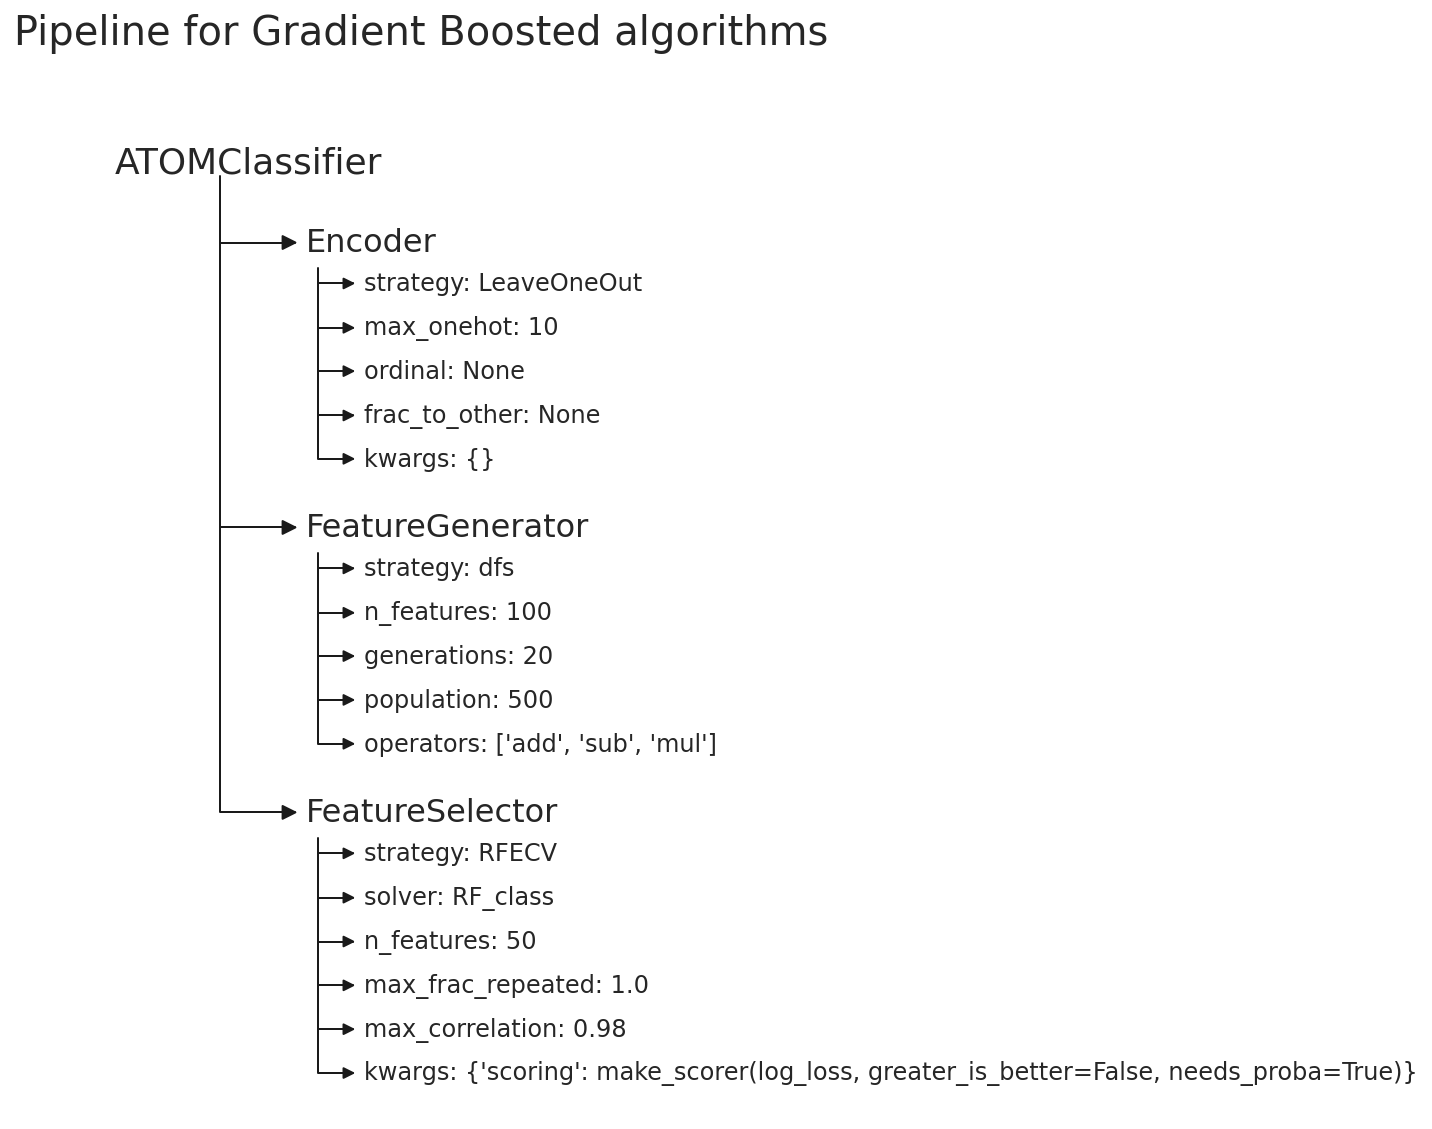

In [39]:
atom.plot_pipeline(title='Pipeline for Gradient Boosted algorithms', figsize=(8,8))

Despite apparent failures of hyperparameters' optimization and feature engineering on a  
particular dataset, all gradient boosted models in question showed robust performance.  

Future steps:  
- reduce the number of hyperparameters being tuned (impossible now for technical reasons)
- drastically increase the number of calls for BO (200-500)
- give the models a try on a different dataset
- implement similar pipeline logic in sklearn (maybe)
- CatBoost crashes ATOM in many function calls, could not explore all useful features of the  
    library, will try to run in a different environment (conda may be a culprit)